# Deep Learning Hackathon

The problem statement deals with creating a CNN Binary Classification Model.

The complete solution in broken into parts:
1. Acquiring and Processing Images
2. Checking image dimensions and trying transformations.
3. Defining the transform functions for train and val/test datasets.
4. Separating images into labelled sub-directories and Performing stratified train-test splits.
5. Building Model
6. Predicting Test set verdicts.

Throughout the problem solving assesment we have used multiple different models:

**Model 1:** Random Model created from scratch.

**Model 2:** Hyperparameter tuning for Model 1.

**Model 3:** Retuning of top 4 models from Model 3 results with early stopping and selecting the best model.

**Model 4:** ResNet with Transfer Learning and early stopping.

**Model 5:** Training ResNet 18 from scratch with early stopping.


## Aquiring the Images from github repo.

1. Clone the repository
2. Extract the images in the zip folders
3. Merge the Images and make them into a unified images folder.

In [1]:
import os
import shutil

if os.path.isdir('/content/Qualcomm-DL-Hackathon'):
  shutil.rmtree('/content/Qualcomm-DL-Hackathon', ignore_errors=True)

In [2]:
# Cloning the github.

!git clone https://github.com/Prashant-AV/Qualcomm-DL-Hackathon.git

Cloning into 'Qualcomm-DL-Hackathon'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 30.68 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
import zipfile
import os

# Define the paths to your ZIP files
zip1_path = '/content/Qualcomm-DL-Hackathon/train/images part-1.zip'
zip2_path = '/content/Qualcomm-DL-Hackathon/train/images part-2.zip'

# Create a directory to extract the contents
extract_dir = '/content/Qualcomm-DL-Hackathon/train/images'
os.makedirs(extract_dir, exist_ok=True)

# Function to extract a ZIP file into the current working directory
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract the contents of both ZIP files into the current working directory
extract_zip(zip1_path, extract_dir)
extract_zip(zip2_path, extract_dir)

In [4]:
import shutil

# Define the directories to merge
dir1 = '/content/Qualcomm-DL-Hackathon/train/images/images part-1'
dir2 = '/content/Qualcomm-DL-Hackathon/train/images/images part-2'

merged_dir = '/content/Qualcomm-DL-Hackathon/train/images'

os.makedirs(merged_dir, exist_ok=True)

# Function to copy contents from one directory to another
def merge_directories(src_dir, dest_dir):
    for item in os.listdir(src_dir):
        s = os.path.join(src_dir, item)
        d = os.path.join(dest_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)

# Merge the contents of both directories
merge_directories(dir1, merged_dir)
merge_directories(dir2, merged_dir)

shutil.rmtree(dir1, ignore_errors=True)
shutil.rmtree(dir2, ignore_errors=True)

## Image PreProcessing

In this section we basically work upon getting the train-val sets of images for the project

1. Load an image and check the dimensions we are working with.
2. Create a transform function for the data set.
3. Create train-val split fom the available data.

In [5]:
import os

import warnings
warnings.filterwarnings("ignore")

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split

### Load an Image to check the dimensions and try transformations    

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

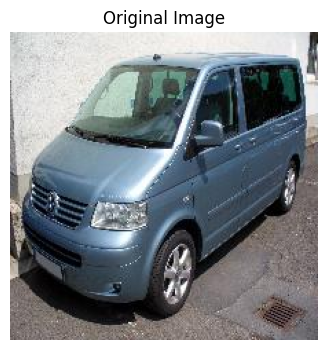

Original Image Dimensions: 224 x 224 pixels


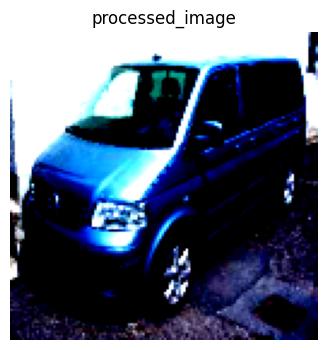

Processed Image Dimensions: 128 x 128 pixels


In [8]:
# Loading the image.
image_path = "/content/Qualcomm-DL-Hackathon/train/images/1022.jpg"
original_image = Image.open(image_path)  # Open the image

# Plotting the Orignal Image.
plt.figure(figsize=(4, 4))
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Get the dimensions
width, height = original_image.size  # .size returns (width, height)

print(f"Original Image Dimensions: {width} x {height} pixels")

# Creating a dummy Transformer
transform_dummy = transforms.Compose([
    transforms.Resize((128,128)),  # Make the image smaller (128x128 pixels)
    transforms.ToTensor(),       # Convert the image into numbers (tensor)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Performs mean substraction.
])

# Processing the loaded Image
processed_image_dummy = transform_dummy(original_image)  # Process the image

processed_image_for_display_dummy = processed_image_dummy.permute(1,2,0).numpy()  # Rearrange for display

# Plotting the Processed Image
plt.figure(figsize=(4, 4))
plt.imshow(processed_image_for_display_dummy)
plt.title("processed_image")
plt.axis("off")
plt.show()

# Get the dimensions
to_pil = transforms.ToPILImage()
image = to_pil(processed_image_for_display_dummy)

width, height = image.size  # .size returns (width, height)
print(f"Processed Image Dimensions: {width} x {height} pixels")



**Conclusion:** Transform function to resize image to 256x256, perform horizontal filp, add colorjitter should be used



## Define Transform functions

In [9]:
# Define transformers both with and without mean substraction and data augmentations.
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])

## Loading Train Data set and Making test data set based on the inputs provided in excel file.

For CNNs, it's generally best to organize dataset so that images of each class are in separate folders. This structure helps in:

Labeling: It makes it easier to label the images correctly during the data loading process.
Data Augmentation: Tools and libraries for data augmentation often expect this structure.
Training Efficiency: It helps in efficiently loading and processing the data during training.

Therefore, separating the training and testing data sets into labels: 'emergency_vehicle' and 'not_emergency_vehicle'

#### Performing train-val split in data set

In [10]:
import pandas as pd

train_csv = pd.read_csv('/content/Qualcomm-DL-Hackathon/train/train.csv')

In [11]:
train_csv.emergency_or_not.value_counts().to_frame() # Not a perfectly balanced data set

,count
emergency_or_not,
0,965
1,681


**Performing stratified splits**

In [12]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_csv, test_size= 0.2, stratify= train_csv['emergency_or_not'], random_state= 7)

train.shape, val.shape

((1316, 2), (330, 2))

#### Creating train and val labelled datasets/directories

Sending the images to different sub-dirs based on the excel sheet provided.

In [13]:
# Making list of all the images of type emergency and non_emergency in train_set.

train_files = list(train_csv.image_names)

train_emergency_vehicle = list(train.loc[train['emergency_or_not'] == 1, 'image_names'])
train_not_emergency_vehicle = list(train.loc[train['emergency_or_not'] == 0, 'image_names'])

len(train_emergency_vehicle), len(train_not_emergency_vehicle)

(544, 772)

In [14]:
# Making list of all the images of type emergency and non_emergency in train_set.

val_files = list(train_csv.image_names)

val_emergency_vehicle = list(val.loc[val['emergency_or_not'] == 1, 'image_names'])
val_not_emergency_vehicle = list(val.loc[val['emergency_or_not'] == 0, 'image_names'])

len(val_emergency_vehicle), len(val_not_emergency_vehicle)

(137, 193)

In [15]:
import shutil
import os

def copier(files, src, dst):
    # Sending files to designated folder
    for file in files:
        file_path = src + rf'/{file}'
        shutil.copy(file_path, dst)

labelled_images_root_path_train = '/content/Qualcomm-DL-Hackathon/train/labelled_set_train'
src = '/content/Qualcomm-DL-Hackathon/train/images'

# Making sub-dirs for emergency and non-emergency labels.
emergency = labelled_images_root_path_train + r'/emergency'
non_emergency = labelled_images_root_path_train + r'/non_emergency'

if os.path.isdir(labelled_images_root_path_train):
    shutil.rmtree(labelled_images_root_path_train, ignore_errors=True)

os.makedirs(emergency, exist_ok=True)
os.makedirs(non_emergency, exist_ok=True)

copier(train_emergency_vehicle, src, emergency)
copier(train_not_emergency_vehicle, src, non_emergency)

In [16]:
labelled_images_root_path_val = '/content/Qualcomm-DL-Hackathon/train/labelled_set_val'
src = '/content/Qualcomm-DL-Hackathon/train/images'

# Making sub-dirs for emergency and non-emergency labels.
emergency = labelled_images_root_path_val + '/emergency'
non_emergency = labelled_images_root_path_val + '/non_emergency'

if os.path.isdir(labelled_images_root_path_val):
    shutil.rmtree(labelled_images_root_path_val, ignore_errors=True)

os.makedirs(emergency, exist_ok=True)
os.makedirs(non_emergency, exist_ok=True)

copier(val_emergency_vehicle, src, emergency)
copier(val_not_emergency_vehicle, src, non_emergency)

In [17]:
labelled_images_root_path_train, labelled_images_root_path_val

('/content/Qualcomm-DL-Hackathon/train/labelled_set_train',
 '/content/Qualcomm-DL-Hackathon/train/labelled_set_val')

#### Loading and Transforming Train and Test Dataset

Using the transformation with mean_substraction

In [18]:
# Loading train dataset
train_dataset = datasets.ImageFolder(root= labelled_images_root_path_train, transform= train_transform)
val_dataset = datasets.ImageFolder(root= labelled_images_root_path_val, transform= test_transform)

In [19]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1316
    Root location: /content/Qualcomm-DL-Hackathon/train/labelled_set_train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
val_dataset

Dataset ImageFolder
    Number of datapoints: 330
    Root location: /content/Qualcomm-DL-Hackathon/train/labelled_set_val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Building and Training Model

**Making data loaders for train and val datasets**

In [21]:
# Creating data loader to help load files in batch from dataset to help reduce memory useage.

batchsize = 32

train_loader = DataLoader(train_dataset, batch_size= batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batchsize, shuffle=False)

**Creating Early Stopping Class**

In [22]:
# Creating Early Stopping Class to stop the epocs if for 3 continuous runs validation loss is increasing. This avoids overfitting

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

**Defiing a function to reset weights in models**

In [23]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models


### **Model 1:** Random Model created from scratch.

Defining Model

In [25]:
model_1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Pooling

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),  # Flatten the 3D tensor into a 1D vector

    nn.Linear(512 * 16 * 16, 512),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 512),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 2),          # Output layer for binary classification
    nn.Softmax()                # Applying softmax to classify it as class emergency or not-emergency
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(model_1.parameters(), lr=0.01)

print(model_1.parameters)

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=131072, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=512, out_features=512, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.3, inplace=False)

Training Model

In [26]:
epochs = 15
early_stopping = EarlyStopping(patience= 5, min_delta= 0)
model_1.apply(reset_weights)

for epoch in range(epochs):
    model_1.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:
        # Forward pass
        outputs = model_1(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        prob, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluate the model on the validation set for early stopping.

    model_1.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_1(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.2f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping!!!")
        break

KeyboardInterrupt: 

In [ ]:
model_1.eval()  # Set the model to evaluation mode
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_18(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy_resnet = 100 * val_correct / val_total
print(f'Validation Accuracy: {val_accuracy_resnet:.2f}%')

### Model 3: Tuning the hyperparameter tuned top 3 models with more epochs and early stopping


#### **3a:**

**Hypertuned Model Stats:**

Epoch [1/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=2, hidden_units=256: Loss=0.6775, Accuracy=60.33%

Epoch [2/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=2, hidden_units=256: Loss=0.6089, Accuracy=68.09%

Epoch [3/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=2, hidden_units=256: Loss=0.5965, Accuracy=70.06%

Epoch [4/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=2, hidden_units=256: Loss=0.5992, Accuracy=70.59%

Epoch [5/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=2, hidden_units=256: Loss=0.6217, Accuracy=68.09%

Validation Accuracy for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=2, hidden_units=256: 71.52%


In [ ]:
# Creating a loader to help load files in batch from dataset to help reduce memory useage.

batchsize = 32

train_loader = DataLoader(train_dataset, batch_size= batchsize, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batchsize, shuffle= False)

model_3a = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Pooling

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),  # Flatten the 3D tensor into a 1D vector

    nn.Linear(512 * 16 * 16, 256),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256, 256),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256, 2),          # Output layer for binary classification
    nn.Softmax()                # Applying softmax to classify it as class emergency or not-emergency
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(model_3a.parameters(), lr=0.001)

model_3a.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=131072, out_features=256, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=256, out_features=256, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.5, inplace=False)

**Training model_3a**

In [ ]:
epochs = 10
model_3a.apply(reset_weights)

early_stopping = EarlyStopping(patience= 3, min_delta= 0.01)

for epoch in range(epochs):
    model_3a.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:
        # Forward pass
        outputs = model_3a(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        prob, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluate the model on the validation set

    model_3a.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_3a(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.2f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch [1/10], Loss: 0.6633, Accuracy: 62.46%
Validation Accuracy: 71.21%, Validation Loss: 0.59
Epoch [2/10], Loss: 0.6075, Accuracy: 70.06%
Validation Accuracy: 70.00%, Validation Loss: 0.61
Epoch [3/10], Loss: 0.5970, Accuracy: 70.90%
Validation Accuracy: 70.61%, Validation Loss: 0.61
Epoch [4/10], Loss: 0.5959, Accuracy: 71.35%
Validation Accuracy: 69.09%, Validation Loss: 0.61
Early stopping


In [ ]:
model_3a.eval()  # Set the model to evaluation mode
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_3a(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy_3a = 100 * val_correct / val_total
print(f'Validation Accuracy on model 3a: {val_accuracy_3a:.2f}%')

Validation Accuracy on model 3a: 69.09%


#### **3b:**

**Hypertuned Model Stats:**

Epoch [1/5] for lr=0.001, batch_size=16, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.6767, Accuracy=58.74%

Epoch [2/5] for lr=0.001, batch_size=16, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.6403, Accuracy=63.15%

Epoch [3/5] for lr=0.001, batch_size=16, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.6105, Accuracy=69.00%

Epoch [4/5] for lr=0.001, batch_size=16, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.5908, Accuracy=71.66%

Epoch [5/5] for lr=0.001, batch_size=16, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.6277, Accuracy=68.16%

Validation Accuracy for lr=0.001, batch_size=16, dropout=0.5, hidden_layers=3, hidden_units=128: 70.91%



In [ ]:
# Creating a loader to help load files in batch from dataset to help reduce memory useage.

batchsize = 16

train_loader = DataLoader(train_dataset, batch_size= batchsize, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batchsize, shuffle= False)

model_3b = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Pooling

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),  # Flatten the 3D tensor into a 1D vector

    nn.Linear(512 * 16 * 16, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 2),          # Output layer for binary classification
    nn.Softmax()                # Applying softmax to classify it as class emergency or not-emergency
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(model_3b.parameters(), lr=0.001)

model_3b.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=131072, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=128, out_features=128, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.5, inplace=False)

**Training model_3b**

In [ ]:
epochs = 10
model_3b.apply(reset_weights)

early_stopping = EarlyStopping(patience= 3, min_delta= 0.01)

for epoch in range(epochs):
    model_3b.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:
        # Forward pass
        outputs = model_3b(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        prob, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluate the model on the validation set

    model_3b.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_3b(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.2f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch [1/10], Loss: 0.6846, Accuracy: 57.29%
Validation Accuracy: 58.48%, Validation Loss: 0.67
Epoch [2/10], Loss: 0.7107, Accuracy: 58.66%
Validation Accuracy: 58.48%, Validation Loss: 0.70
Epoch [3/10], Loss: 0.6698, Accuracy: 58.97%
Validation Accuracy: 58.48%, Validation Loss: 0.72
Epoch [4/10], Loss: 0.7292, Accuracy: 58.74%
Validation Accuracy: 58.48%, Validation Loss: 0.72
Early stopping


In [ ]:
model_3b.eval()  # Set the model to evaluation mode
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_3b(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy_3b = 100 * val_correct / val_total
print(f'Validation Accuracy on model 3b: {val_accuracy_3b:.2f}%')

Validation Accuracy on model 3b: 58.48%


#### **3c:**

**Hypertuned Model Stats:**

Epoch [1/5] for lr=0.001, batch_size=32, dropout=0.3, hidden_layers=2, hidden_units=128: Loss=0.7353, Accuracy=55.62%

Epoch [2/5] for lr=0.001, batch_size=32, dropout=0.3, hidden_layers=2, hidden_units=128: Loss=0.6234, Accuracy=68.54%

Epoch [3/5] for lr=0.001, batch_size=32, dropout=0.3, hidden_layers=2, hidden_units=128: Loss=0.5904, Accuracy=71.05%

Epoch [4/5] for lr=0.001, batch_size=32, dropout=0.3, hidden_layers=2, hidden_units=128: Loss=0.5864, Accuracy=72.49%

Epoch [5/5] for lr=0.001, batch_size=32, dropout=0.3, hidden_layers=2, hidden_units=128: Loss=0.5717, Accuracy=73.02%

Validation Accuracy for lr=0.001, batch_size=32, dropout=0.3, hidden_layers=2, hidden_units=128: 70.61%



In [ ]:
# Creating a loader to help load files in batch from dataset to help reduce memory useage.

batchsize = 32

train_loader = DataLoader(train_dataset, batch_size= batchsize, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batchsize, shuffle= False)

model_3c = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Pooling

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),  # Flatten the 3D tensor into a 1D vector

    nn.Linear(512 * 16 * 16, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, 2),          # Output layer for binary classification
    nn.Softmax()                # Applying softmax to classify it as class emergency or not-emergency
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(model_3c.parameters(), lr=0.001)

model_3c.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=131072, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=128, out_features=128, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.3, inplace=False)

**Training model_3c**

In [ ]:
epochs = 10
model_3c.apply(reset_weights)

early_stopping = EarlyStopping(patience= 3, min_delta= 0.01)

for epoch in range(epochs):
    model_3c.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:
        # Forward pass
        outputs = model_3c(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        prob, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluate the model on the validation set

    model_3c.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_3c(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.2f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch [1/10], Loss: 0.6605, Accuracy: 61.25%
Validation Accuracy: 68.48%, Validation Loss: 0.61
Epoch [2/10], Loss: 0.6002, Accuracy: 69.00%
Validation Accuracy: 70.61%, Validation Loss: 0.58
Epoch [3/10], Loss: 0.5773, Accuracy: 72.64%
Validation Accuracy: 70.00%, Validation Loss: 0.61
Epoch [4/10], Loss: 0.6746, Accuracy: 64.13%
Validation Accuracy: 58.48%, Validation Loss: 0.70
Epoch [5/10], Loss: 0.7336, Accuracy: 58.66%
Validation Accuracy: 58.48%, Validation Loss: 0.70
Early stopping


In [ ]:
model_3c.eval()  # Set the model to evaluation mode
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_3c(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy_3c = 100 * val_correct / val_total
print(f'Validation Accuracy on model 3b: {val_accuracy_3c:.2f}%')

Validation Accuracy on model 3b: 58.48%


#### **3d:**

**Hypertuned Model Stats:**

Epoch [1/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.6791, Accuracy=58.05%

Epoch [2/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.6305, Accuracy=66.41%

Epoch [3/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.5957, Accuracy=69.68%

Epoch [4/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.5957, Accuracy=70.74%

Epoch [5/5] for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=3, hidden_units=128: Loss=0.6156, Accuracy=69.60%

Validation Accuracy for lr=0.001, batch_size=32, dropout=0.5, hidden_layers=3, hidden_units=128: 70.00%



In [ ]:
# Creating a loader to help load files in batch from dataset to help reduce memory useage.

batchsize = 32

train_loader = DataLoader(train_dataset, batch_size= batchsize, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batchsize, shuffle= False)

model_3d = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Pooling

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Conv layer 3
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),  # Flatten the 3D tensor into a 1D vector

    nn.Linear(512 * 16 * 16, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 128),  # Fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 2),          # Output layer for binary classification
    nn.Softmax()                # Applying softmax to classify it as class emergency or not-emergency
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(model_3d.parameters(), lr=0.001)

model_3d.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=131072, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=128, out_features=128, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.5, inplace=False)

**Training model_3d**

In [ ]:
epochs = 10
model_3d.apply(reset_weights)

early_stopping = EarlyStopping(patience= 3, min_delta= 0.01)

for epoch in range(epochs):
    model_3d.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:
        # Forward pass
        outputs = model_3d(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        prob, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluate the model on the validation set

    model_3d.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_3d(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.2f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch [1/10], Loss: 0.7056, Accuracy: 56.76%
Validation Accuracy: 58.48%, Validation Loss: 0.70
Epoch [2/10], Loss: 0.7243, Accuracy: 58.59%
Validation Accuracy: 58.48%, Validation Loss: 0.70
Epoch [3/10], Loss: 0.7278, Accuracy: 58.74%
Validation Accuracy: 58.48%, Validation Loss: 0.70
Epoch [4/10], Loss: 0.7179, Accuracy: 58.66%
Validation Accuracy: 58.48%, Validation Loss: 0.70
Early stopping


In [ ]:
model_3d.eval()  # Set the model to evaluation mode
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_3d(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy_3d = 100 * val_correct / val_total
print(f'Validation Accuracy on model 3b: {val_accuracy_3d:.2f}%')

Validation Accuracy on model 3b: 58.48%


#### Selecting the best of four model as model_3

In [ ]:
# Change the model to model which has highest accuracy on val data set.

model_3 = model_3a
accuracy = val_accuracy_3a

if val_accuracy_3b > accuracy:
    model_3 = model_3b
    accuracy = val_accuracy_3b

if val_accuracy_3c > accuracy:
    model_3 = model_3c
    accuracy = val_accuracy_3c

if val_accuracy_3d > accuracy:
    model_3 = model_3d
    accuracy = val_accuracy_3d

accuracy


69.0909090909091

## Test Set prediction

#### Using Model 3

In [ ]:
import pandas as pd

test_csv = pd.read_csv(r"C:\Dropbox\GenAI\Analytics_Vidhya\Hackathons\Deep_Learning_Hackathon\test.csv")

# Defaulting all vehicles to be classified as emergency
test_csv['emergency_or_not'] = 1

test_csv.head()

train_dataset.classes

['emergency', 'non_emergency']

In [ ]:
# We open images one by one and eval them via our model.

for img in test_csv.image_names:
    # Load a single image
    image_path = rf"{src}\{img}"
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)  # Apply transformations and add batch dimension

    # Perform inference
    model_3.eval()

    with torch.no_grad():
        output = model_3(image)
        prob, pred = torch.max(output, 1)

        if pred:
            test_csv.loc[test_csv['image_names'] == img, 'emergency_or_not'] = 0
        else:
            print(f"Predicted Class: {train_dataset.classes[pred]}")


test_csv.to_csv(r'C:\Dropbox\GenAI\Analytics_Vidhya\Hackathons\Deep_Learning_Hackathon\Soultion3.csv', index=False)


Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
Predicted Class: emergency
P